# Copula Strategy Using Mispricing Index
This notebook demonstrates the usage of the `copula_strategy_mpi` module.
The framework of which was originally proposed in

* Xie, W., Liew, R.Q., Wu, Y. and Zou, X., 2016. Pairs trading with copulas. 

### 1. Importing and data preprocessing

In [1]:
# Importing libraries and modules
import pandas as pd
import numpy as np
import datetime as dt  # For plotting x-axis as dates
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arbitragelab.copula_approach.copula_strategy_mpi import CopulaStrategyMPI
import arbitragelab.copula_approach.copula_calculation as ccalc

In [2]:
# Importing data
pair_prices = pd.read_csv(r'BKD_ESC_2008_2009_June.csv', index_col=0)
# Formatting dates
formatted_dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in pair_prices.index]
pair_prices.index = formatted_dates

BKD_series = pair_prices['BKD']
ESC_series = pair_prices['ESC']

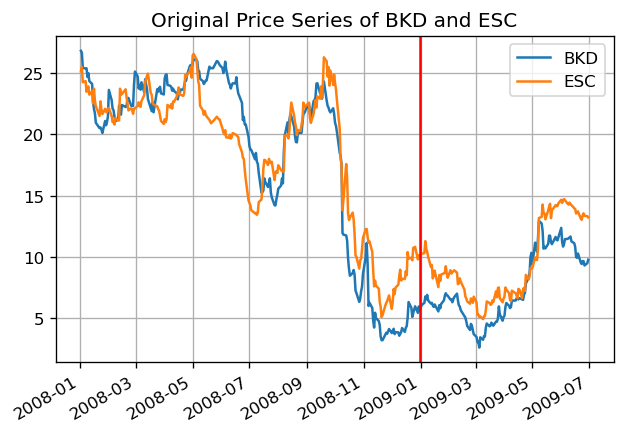

In [3]:
plt.figure(dpi=120)
plt.plot(formatted_dates, BKD_series, label='BKD')
plt.plot(formatted_dates, ESC_series, label='ESC')
plt.axvline(dt.date(2008, 12, 31), color='red')  # Training testing split date
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
plt.title(r'Original Price Series of BKD and ESC')
plt.show()

In [4]:
# Initiate the analysis module
CSMPI = CopulaStrategyMPI()


# Training and testing split. Note that this module works with returns series.
training_length = 252# From 01/02/2008 to 12/30/2008 (m/d/y)

BKD_train = CSMPI.to_returns(BKD_series[ : training_length])
ESC_train = CSMPI.to_returns(ESC_series[ : training_length])
BKD_train_prices = BKD_series[ : training_length]
ESC_train_prices = ESC_series[ : training_length]
# train_dates = formatted_dates[ : training_length]

BKD_test = CSMPI.to_returns(BKD_series[training_length : ])
ESC_test = CSMPI.to_returns(ESC_series[training_length : ])
BKD_test_prices = BKD_series[training_length : ]
ESC_test_prices = ESC_series[training_length : ]
# test_dates = formatted_dates[training_length : ]

# Empirical CDF for the training set.
cdf1 = ccalc.find_marginal_cdf(BKD_train)
cdf2 = ccalc.find_marginal_cdf(ESC_train)

cdf1_price = ccalc.find_marginal_cdf(BKD_train_prices)
cdf2_price = ccalc.find_marginal_cdf(ESC_train_prices)

Let's at first scatter plot the training data to have a grasp on its dependence structure, and determine which copula it should fit.

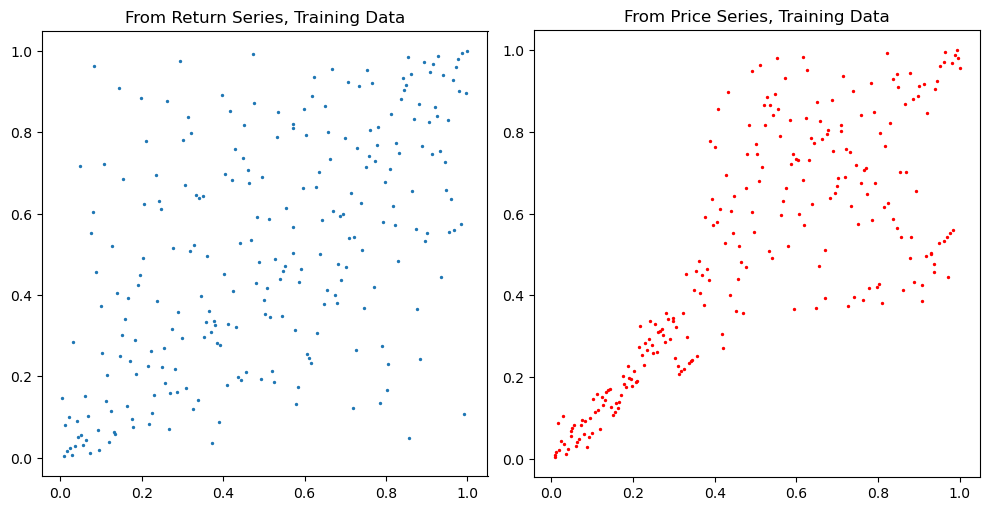

In [5]:
# Scatter plot the training data.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=100)
axs[0].scatter(cdf1(BKD_train), cdf2(ESC_train), s=2)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title(r'From Return Series, Training Data')

axs[1].scatter(cdf1_price(BKD_train_prices), cdf2_price(ESC_train_prices), s=2, color='r')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_title(r'From Price Series, Training Data')
plt.tight_layout()
plt.show()

**Note: We only use the returns series for the MPI strategy. The price series scatter plot is just for visual comparison.**

The returns plot exhibits some tail dependencies on the lower-left corner.
There might also be some tail dependencies on the upper-right corner, but it is not directly obvious.
When compared to the price series scatter plot, the price series shows much stronger lower dependency and no clear upper dependency.
In terms of market movement, the two plots indicate that both returns and prices tend to move downward together, but not upward together, at least the interdependence is not as strong as downward movements.
Considering the training data is in year 2008, those scatter plots make sense.

Regarding which copulas best describe the structure, we propose using N14 and Student-t for their strong lower dependencies, and similarities on the upper right corner.
One may fit to as much the copulas as they wish in the `copula_approach` package.

In [6]:
# Fit to N13, Clayton and Student-t , Gumbel, Frank, N14 copulas respectively, and print the scores.
result_dict_n13,     copula_n13, _, _     = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='N13')
result_dict_clayton, copula_clayton, _, _ = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Clayton')
result_dict_t,       copula_t, _, _       = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Student')
result_dict_gumbel,  copula_gumbel, _, _  = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Gumbel')
result_dict_frank,   copula_frank, _, _   = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Frank')
result_dict_n14,     copula_n14, _, _     = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='N14')

# Print fit scores
print(result_dict_n13)
print(result_dict_clayton)
print(result_dict_t)
print(result_dict_gumbel)
print(result_dict_frank)
print(result_dict_n14)

{'Copula Name': 'N13', 'SIC': -105.94681640898858, 'AIC': -109.4602454965, 'HQIC': -108.05607635438662}
{'Copula Name': 'Clayton', 'SIC': -101.88027859448783, 'AIC': -105.39370768199925, 'HQIC': -103.98953853988587}
{'Copula Name': 'Student', 'SIC': -121.7779694993804, 'AIC': -125.29139858689182, 'HQIC': -123.88722944477844}
{'Copula Name': 'Gumbel', 'SIC': -105.26036256358641, 'AIC': -108.77379165109782, 'HQIC': -107.36962250898445}
{'Copula Name': 'Frank', 'SIC': -90.70833326562915, 'AIC': -94.22176235314056, 'HQIC': -92.81759321102719}
{'Copula Name': 'N14', 'SIC': -128.5867816510987, 'AIC': -132.10021073861014, 'HQIC': -130.69604159649674}


Note that we are working with the returns series, which in general is much noisier than price series, and has a lower level of correlation.

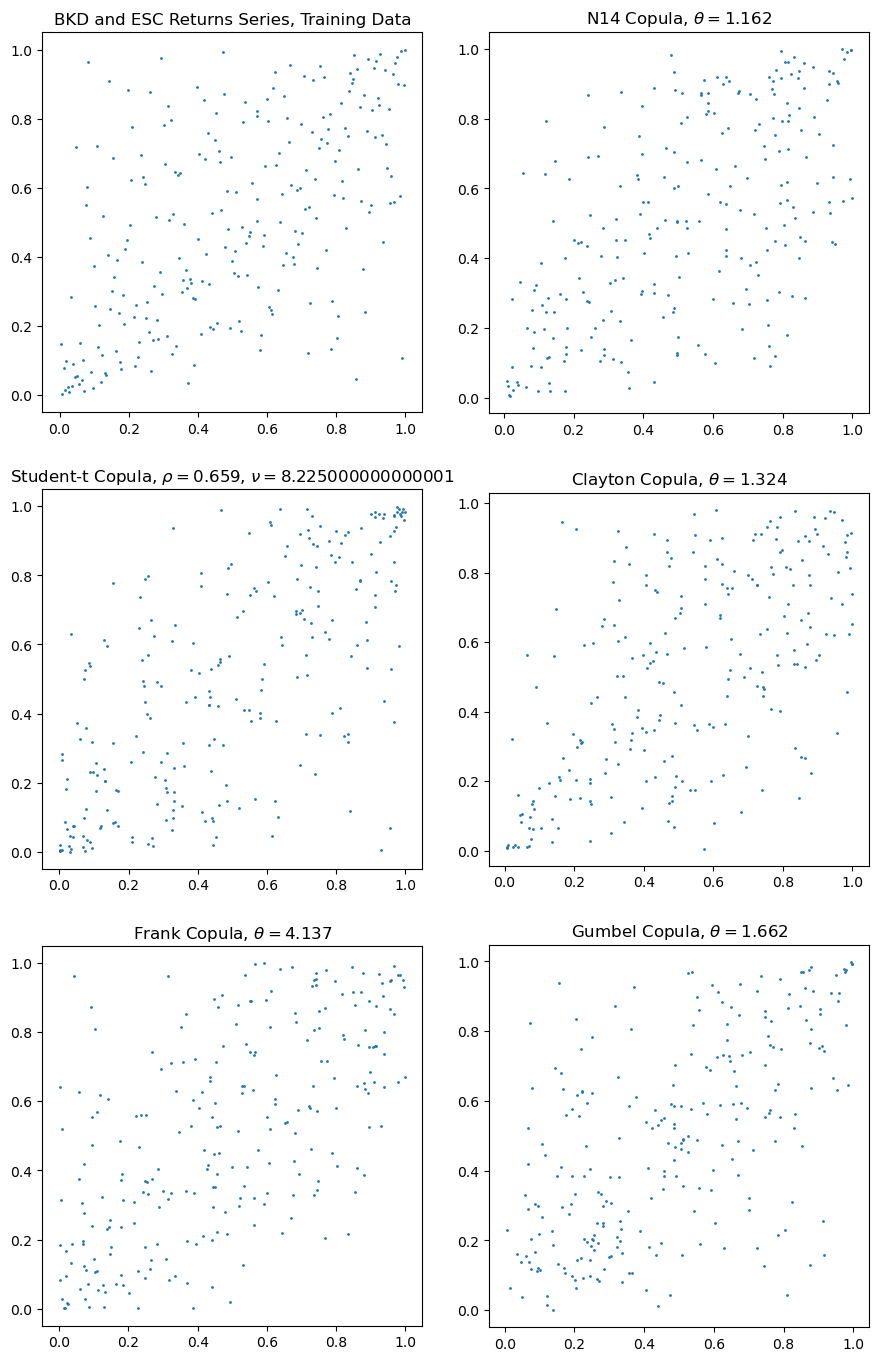

In [7]:
# Scatter plot the training data vs the fitted copulas
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9,14), dpi=100)
# axs[0, 0]: Empirical.
axs[0, 0].scatter(cdf1(BKD_train), cdf2(ESC_train), s=1)
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_title(r'BKD and ESC Returns Series, Training Data')
axs[0, 0].set_xlim([-0.05, 1.05])
axs[0, 0].set_ylim([-0.05, 1.05])
plt.tight_layout()

# axs[0, 1]: N14.
CSMPI.graph_copula(copula_name='N14', theta=copula_n14.theta,
                   ax=axs[0, 1], s=1, num=len(ESC_train))

# axs[1, 0]: Student-t.
CSMPI.graph_copula(copula_name='Student', cov=copula_t.cov, nu=copula_t.nu,
                   ax=axs[1, 0], s=1, num=len(ESC_train))
# axs[1, 1]: Clayton.
CSMPI.graph_copula(copula_name='Clayton', theta=copula_clayton.theta,
                   ax=axs[1, 1], s=1, num=len(ESC_train))
# axs[2, 0]: Frank.
CSMPI.graph_copula(copula_name='Frank', theta=copula_frank.theta,
                   ax=axs[2, 0], s=1, num=len(ESC_train))
# axs[2, 1]: Gumbel.
CSMPI.graph_copula(copula_name='Gumbel', theta=copula_gumbel.theta,
                   ax=axs[2, 1], s=1, num=len(ESC_train))
plt.show()

Now we choose Student-t and N14 copula to generate trading signals.

We are using a dollar neutral strategy, and the buy/sell/hold is based on "flag" series, calculated from accumulations of mispricing indices.
For more detail, please refer to the beginning of the notebook.

In [8]:
# Make two strategy classes with the fitted Student and N14 copula.
CSMPI_t = CopulaStrategyMPI(copula=copula_t)
CSMPI_n14 = CopulaStrategyMPI(copula=copula_n14)

# Get positions and flag series
returns_test = pd.concat([BKD_test, ESC_test], axis=1)
positions_t, flags_t     = CSMPI_t.get_positions_and_flags(returns=returns_test, cdf1=cdf1, cdf2=cdf2)
positions_n14, flags_n14 = CSMPI_n14.get_positions_and_flags(returns=returns_test, cdf1=cdf1, cdf2=cdf2)
# Shift the positions by 1 day
positions_t = positions_t.shift(1)
positions_n14 = positions_n14.shift(1)
positions_t[0] = 0
positions_n14[0] = 0

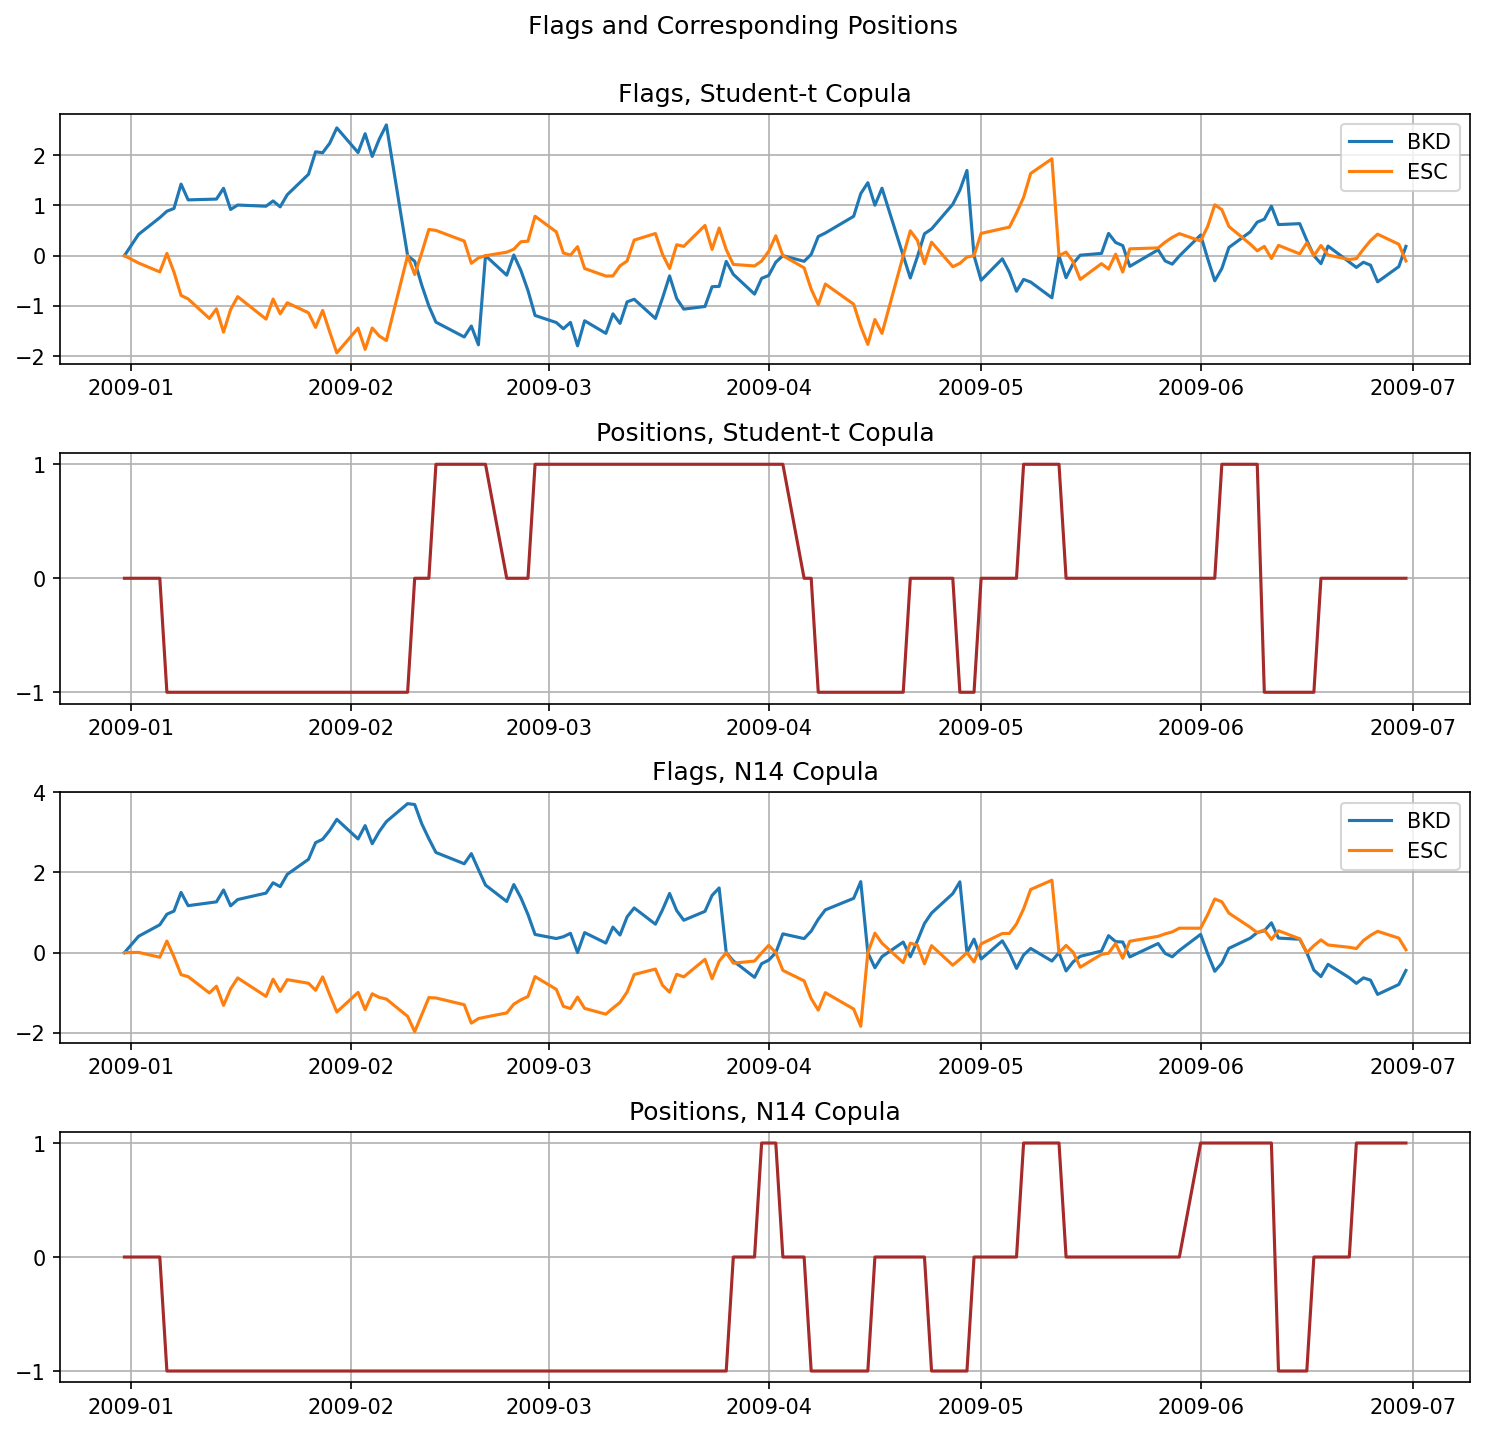

In [22]:
# Plot positions and flags
fig, axs = plt.subplots(4, 1, gridspec_kw={'height_ratios': [1, 1, 1, 1]}, figsize=(10,10), dpi=150)
fig.suptitle('Flags and Corresponding Positions')
# Plotting flags for Student-t copula
axs[0].plot(flags_t['BKD'], label='BKD')
axs[0].plot(flags_t['ESC'], label='ESC')
axs[0].title.set_text('Flags, Student-t Copula')
axs[0].legend()
axs[0].grid()
# Plotting positions for Student-t copula
axs[1].plot(positions_t, label='Positions', color='brown')
axs[1].title.set_text('Positions, Student-t Copula')
axs[1].grid()
axs[1].set_yticks([-1,0,1])
# Plotting flags for N14 copula
axs[2].plot(flags_n14['BKD'], label='BKD')
axs[2].plot(flags_n14['ESC'], label='ESC')
axs[2].title.set_text('Flags, N14 Copula')
axs[2].legend()
axs[2].grid()
# Plotting positions for N14 copula
axs[3].plot(positions_n14, label='Positions', color='brown')
axs[3].title.set_text('Positions, N14 Copula')
axs[3].grid()
axs[3].set_yticks([-1,0,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Avoid title overlap
plt.show()

## Forming Equity Curves
The authors proposes a dollar-neutral trading strategy worded as follows:

Opening rules:
* When FlagX reaches D, we short-sell stock X and buy stock Y in **equal amounts**. (-1 Position)
* When FlagX reaches -D, we short-sell stock Y and buy stock X in **equal amounts**. (1 Position)
* When FlagY reaches D, we short-sell stock Y and buy stock X in **equal amounts**. (1 Position)
* When FlagY reaches -D, we short-sell stock X and buy stock Y in **equal amounts**. (-1 Position)

Exiting rules:
* If trades are opened based on FlagX, then they are closed if FlagX returns to zero or
  reaches stop-loss position S or -S.
* If they are opened based on FlagY, then they are closed if FlagY returns to zero or reaches stop-loss      
  position S or -S.
* After trades are closed, both FlagX and FlagY are reset to zero.

Therefore, we can represent the P&L of the strategy in returns.

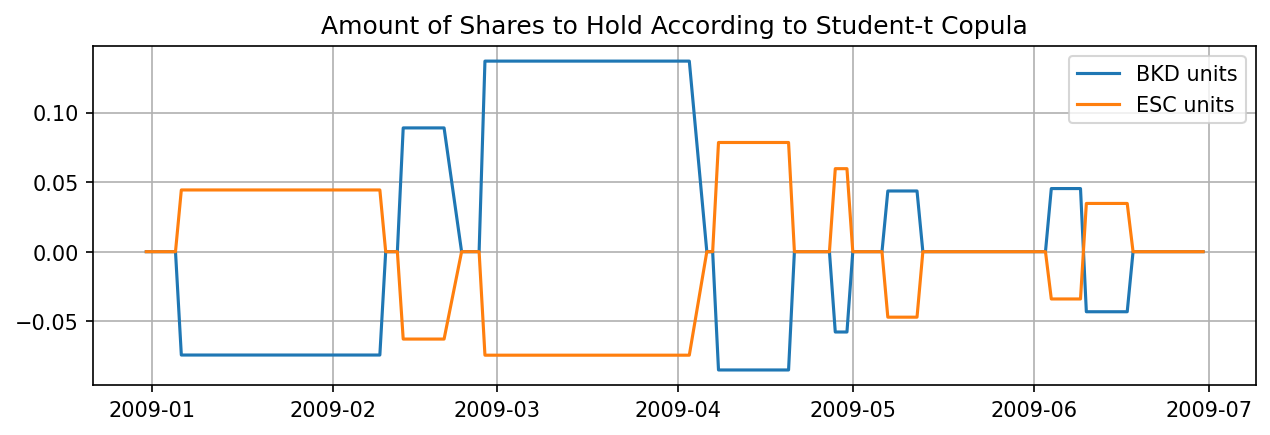

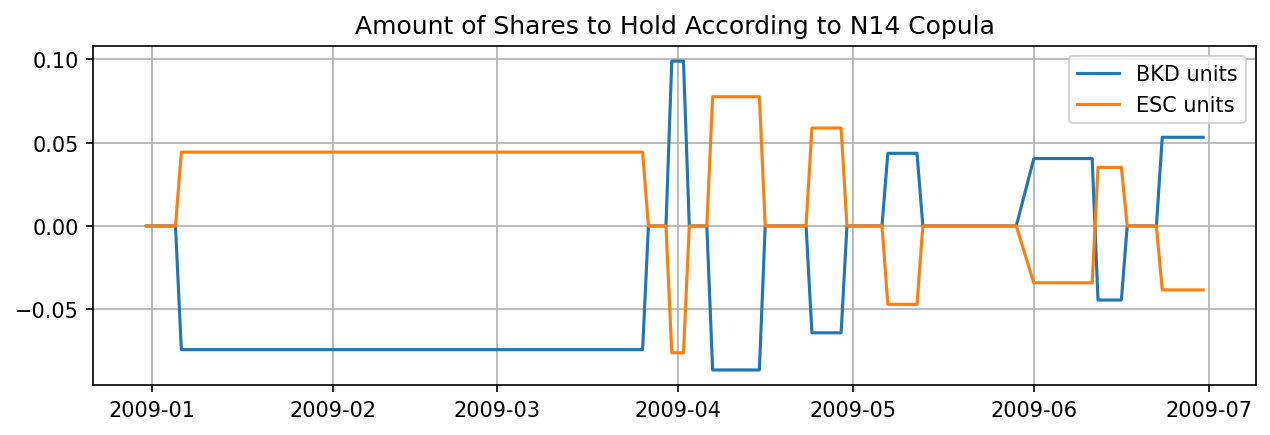

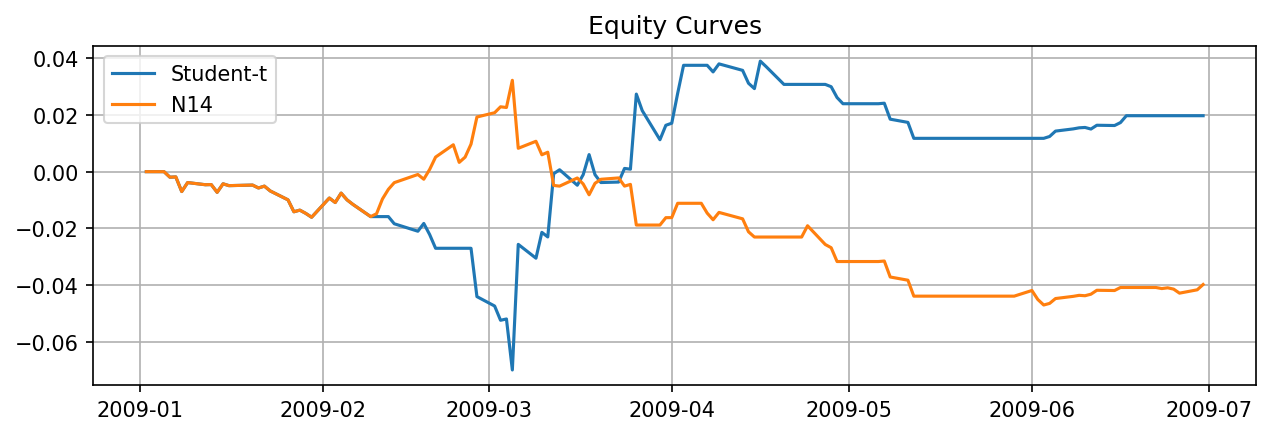

In [21]:
# Calculate returns from the strategy, i.e., assuming 1$ initial investment and calculate P&L.
# 1. Calculate the unit holding series
test_prices = pd.concat([BKD_test_prices, ESC_test_prices], axis=1)
units_df_t = CSMPI.positions_to_units(prices_df=test_prices, positions=positions_t)
units_df_n14 = CSMPI.positions_to_units(prices_df=test_prices, positions=positions_n14)
# 2. Plot the units series
plt.figure(figsize=(10, 3), dpi=150)
plt.plot(units_df_t['BKD'], label='BKD units')
plt.plot(units_df_t['ESC'], label='ESC units')
plt.title('Amount of Shares to Hold According to Student-t Copula')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 3), dpi=150)
plt.plot(units_df_n14['BKD'], label='BKD units')
plt.plot(units_df_n14['ESC'], label='ESC units')
plt.title('Amount of Shares to Hold According to N14 Copula')
plt.legend()
plt.grid()
plt.show()

# 3. Calculate Daily P&L of the strategy based on the units holding for each security
portfolio_pnl_t = BKD_test * units_df_t['BKD'] + ESC_test * units_df_t['ESC']
portfolio_pnl_n14 = BKD_test * units_df_n14['BKD'] + ESC_test * units_df_n14['ESC']

# 4. Calculate and plot the equity curve
equity_t = portfolio_pnl_t.cumsum()
equity_n14 = portfolio_pnl_n14.cumsum()

plt.figure(figsize=(10, 3), dpi=150)
plt.plot(equity_t, label='Student-t')
plt.plot(equity_n14, label='N14')
plt.title('Equity Curves')
plt.legend()
plt.grid()
plt.show()

## References ##
- [Xie, W., Liew, R.Q., Wu, Y. and Zou, X., 2016. Pairs trading with copulas. The Journal of Trading, 11(3), pp.41-52.](https://efmaefm.org/0efmameetings/EFMA%20ANNUAL%20MEETINGS/2014-Rome/papers/EFMA2014_0222_FullPaper.pdf)